The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


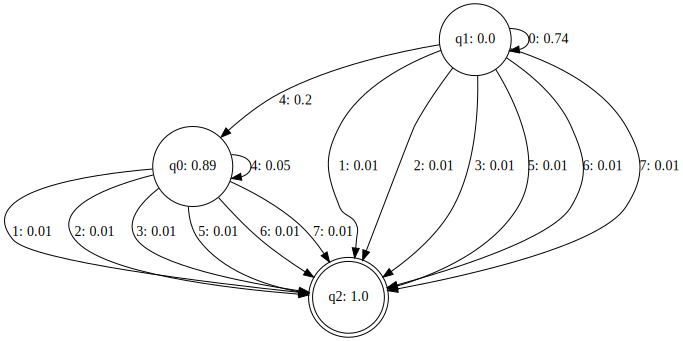

In [6]:

%load_ext autoreload
%autoreload 2
from wombats import pdfa

model = pdfa.PDFA(configFileName='config/pdfa_self_driving_config.yaml')

numSamples = 1e3
traces, traceLengths = model.generateTraces(numSamples)

fName = 'PDFASamples_train.swag'
model.writeTracesToFile(fName, traces, numSamples, traceLengths)

model.drawIPython()

# Flexfringe Usage

Two choices: Using it via Python function calls, or working with the command line.

## Step 1

Install all dependencies and compile flexfringe (development branch due to some technicalities using WIFEXITED macro used for the SAT solver's process)

In [ ]:
# for the C++ code
!apt install graphviz
!apt install libgsl-dev
!apt install libpopt-dev

# for visualization and notebook interface
!pip install graphviz

# Stamina data
!wget http://stamina.chefbe.net/downloads/grid.tar.gz
!tar xfz grid.tar.gz

# cloning the repository
!rm -rf dfasat
!git clone https://bitbucket.org/chrshmmmr/dfasat.git

In [ ]:
# building the repository
# it is important to check out the development branch on colab
!cd dfasat && git checkout  && make clean all

## Step 2 
Provide simple command line wrappers

In [15]:
import subprocess
import sys
import graphviz

from IPython.display import Image, display

def flexfringe(*args, **kwargs):

    command = ["--help"]

    if(len(kwargs) > 1):
        command = []
    for key in kwargs:
        command += ["-" + key + "=" + kwargs[key]]
    flexfringeCall = ["dfasat/flexfringe",] + command + [args[0]]
    callString = subprocess.run(flexfringeCall, 
                                stdout=subprocess.PIPE).stdout.decode()
    print("%s" % callString)

    try:
        with open("dfafinal.dot") as fh:
            return fh.read()
    except FileNotFoundError:
        print("No output file was generated.")
    return None
    
def show(data):
    if data=="":
        pass
    else:
        g = graphviz.Source(data, format="png")
        g.render()
        display(Image(g.render()))
 

In [ ]:
!ls dfasat/data/staminadata

## Step 3

call the flexfringe function with the filename and named arguments just as described in help. Mind that "heuristic-name" is actually an expression, not a valid name. Use the short form in this case.

The flexringe() call returns a string with the dot output.

In [62]:
!dfasat/flexfringe --help

welcome, running git commit bea192cc5abfd8bd4e1121472f875eea2ea6da69 with: dfasat/flexfringe --help 
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                  evaluation directory.
  -M, --mode=string          

In [65]:
data = flexfringe("PDFASamples_train.swag",
                  h="kldistance",
                  d="kl_data",
                  y='1',
                  G='200')

welcome, running git commit bea192cc5abfd8bd4e1121472f875eea2ea6da69 with: dfasat/flexfringe -h=kldistance -d=kl_data -y=1 -G=200 PDFASamples_train.swag 
sat_program : 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running x1120  x880  x880  x848  x848  x848  x848  x848  x848  x704  x480  x480  x424  x208  x96  x16  x16  m100000  m100000  x16  

found intermediate solution with 19 and 19 red states
No valid solver specified, skipping...



## Step 4
Visualize the output by feeding the dot string to the show() function.

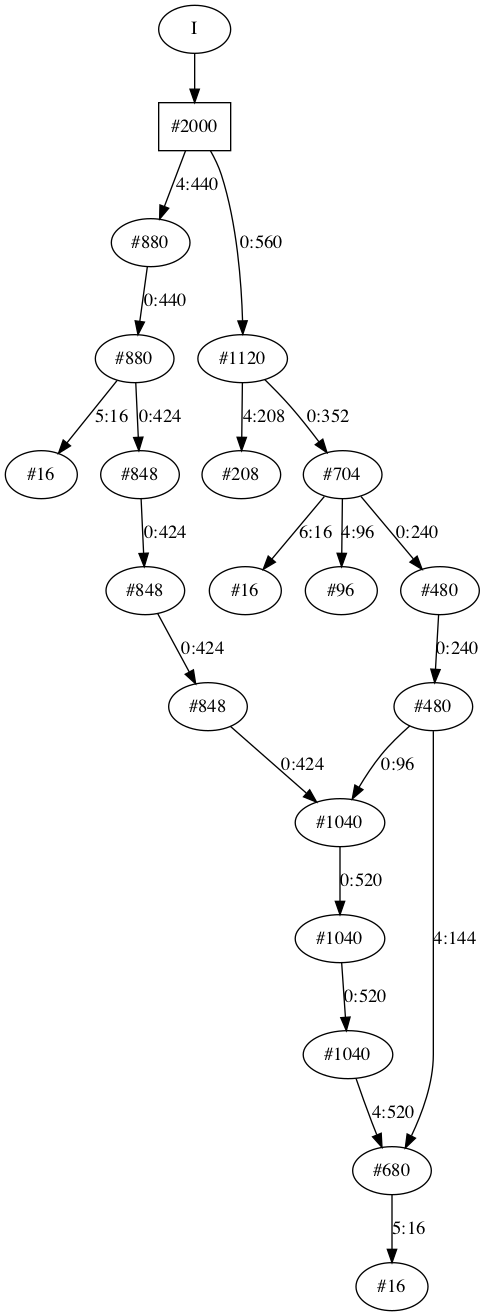

In [66]:
show(data)

## Step 5

Compare with a direct command line. Each cell can act as a shell by prepending a bang ! to the commands.

In [61]:
# !dfasat/flexfringe -h=overlap_driven -d=overlap_data /content/grid/1_training.txt 
!dfasat/flexfringe --help

welcome, running git commit bea192cc5abfd8bd4e1121472f875eea2ea6da69 with: dfasat/flexfringe --help 
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                  evaluation directory.
  -M, --mode=string          

In [ ]:
!dot -Tpng dfafinal.dot > outfile.png

## Step 6

Visualize the files using inline Python calls, e.g. display and Image

In [ ]:
display(Image("outfile.png"))